This notebook serves to do some manual feature engineering for our SVM, before we do deeper neural networks. I also write down a shallower neural net that will generate features via machine learning; these features can be used as the inputs to the SVM.

*Features*:
- Fourier/DCT Transform
- Wavelets
- PCA 
- Pretrained Neural net features

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
import os
import glob
import tqdm
import pywt

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms

from scipy import signal
from sklearn.decomposition import PCA

import cv2

In [2]:
# load in data
train_path = "../../project-data/train_another/"
val_path = "../../project-data/validation_another/"
test_path = "../../project-data/test_another/"
img_size = 128
nchannels = 3

npz_file_listing_train = list(glob.glob(os.path.join(train_path, '**/*.npz')))
npz_file_listing_val = list(glob.glob(os.path.join(val_path, '**/*.npz')))
npz_file_listing_test = list(glob.glob(os.path.join(test_path, '**/*.npz')))
N_train = len(npz_file_listing_train)
N_val = len(npz_file_listing_val)
N_test = len(npz_file_listing_test)

training_data_X = np.zeros((N_train, img_size, img_size, nchannels))
training_data_y = np.zeros(N_train)
val_data_X = np.zeros((N_val, img_size, img_size, nchannels))
val_data_y = np.zeros(N_val)
test_data_X = np.zeros((N_test, img_size, img_size, nchannels))
test_data_y = np.zeros(N_test)

it = 0
for npz_file in tqdm.tqdm(npz_file_listing_train):
    training_data_X[it, :, :, :] = np.load(npz_file)['pixels']
    if "no_" in npz_file:
        training_data_y[it] = 0
    else:
        training_data_y[it] = 1
    it += 1
    
it = 0
for npz_file in tqdm.tqdm(npz_file_listing_val):
    val_data_X[it, :, :, :] = np.load(npz_file)['pixels']
    if "no_" in npz_file:
        val_data_y[it] = 0
    else:
        val_data_y[it] = 1
    it += 1
    
# it = 0
# for npz_file in tqdm.tqdm(npz_file_listing_test):
#     test_data_X[it, :, :, :] = np.load(npz_file)['pixels']
#     if "no_" in npz_file:
#         test_data_y[it] = 0
#     else:
#         test_data_y[it] = 1
#     it += 1

rand_idx = np.random.randint(0, N_train, size=2000)
train_X_sample = training_data_X[rand_idx, :]
train_y_sample = training_data_y[rand_idx]
N_train = 2000

rand_val_idx = np.random.randint(0, N_val, size=1000)
val_X_sample = val_data_X[rand_val_idx, :]
val_y_sample = val_data_y[rand_val_idx]
N_val = 1000

100%|██████████| 2000/2000 [00:07<00:00, 277.43it/s]


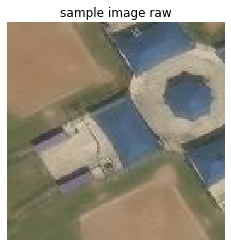

In [6]:
# plot sample image
plt.imshow(train_X_sample[0, :,:,:]/255)
plt.title("sample image raw")
plt.axis('off')
plt.show()

100%|██████████| 2000/2000 [00:02<00:00, 681.24it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


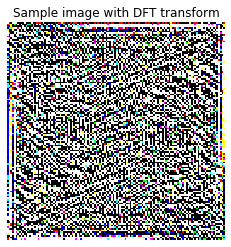

In [7]:
# Fourier transform
train_X_sample_dft = np.zeros(train_X_sample.shape)
for image in tqdm.tqdm(range(N_train)):
    for channel in range(nchannels):
        train_X_sample_dft[image, :, :, channel] = np.real(np.fft.fft2(train_X_sample[image, :, :, channel]))
        
plt.imshow(train_X_sample_dft[0, :,:,:])
plt.title("Sample image with DFT transform")
plt.axis('off')
plt.show()

100%|██████████| 2000/2000 [00:03<00:00, 582.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


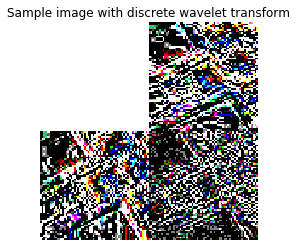

In [8]:
# wavelets
train_X_sample_dwt = np.zeros(train_X_sample.shape)
for image in tqdm.tqdm(range(N_train)):
    for channel in range(nchannels):
        coeffs = pywt.dwt2(train_X_sample[image, :, :, channel], 'haar')
        LL, (LH, HL, HH) = coeffs
        train_X_sample_dwt[image, :, :, channel] = np.block([[LL, LH], [HL, HH]])
        
plt.imshow(train_X_sample_dwt[0, :,:,:])
plt.title("Sample image with discrete wavelet transform")
plt.axis('off')
plt.show()

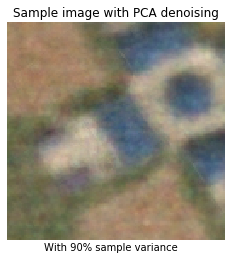

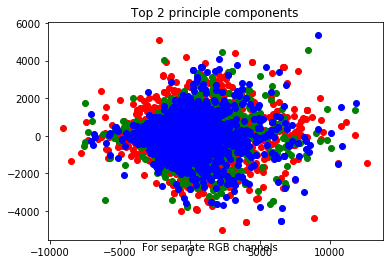

In [41]:
# pca
train_X_sample_red = train_X_sample[:,:,:,0].reshape(N_train, img_size * img_size)
train_X_sample_green = train_X_sample[:,:,:,1].reshape(N_train, img_size * img_size)
train_X_sample_blue = train_X_sample[:,:,:,2].reshape(N_train, img_size * img_size)

train_pca_red = PCA(n_components=0.9)
train_pca_red.fit(train_X_sample_red)
train_pca_green = PCA(n_components=0.9)
train_pca_green.fit(train_X_sample_green)
train_pca_blue = PCA(n_components=0.9)
train_pca_blue.fit(train_X_sample_blue)

red_components = train_pca_red.transform(train_X_sample_red)
green_components = train_pca_green.transform(train_X_sample_green)
blue_components = train_pca_blue.transform(train_X_sample_blue)

projected_red = train_pca_red.inverse_transform(red_components)
projected_green = train_pca_green.inverse_transform(green_components)
projected_blue = train_pca_blue.inverse_transform(blue_components)

out = np.zeros(train_X_sample.shape)
out[:,:,:,0] = projected_red.reshape(N_train, img_size, img_size)
out[:,:,:,1] = projected_green.reshape(N_train, img_size, img_size)
out[:,:,:,2] = projected_blue.reshape(N_train, img_size, img_size)

plt.imshow(out[0,:,:,:]/255)
plt.title("Sample image with PCA denoising")
plt.figtext(x=0.5, y=0.09, s="With 90% sample variance", ha='center')
plt.axis('off')
plt.show()

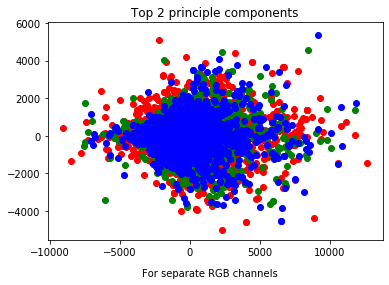

In [42]:
plt.scatter(red_components[:,0], red_components[:,1], c="red")
plt.scatter(green_components[:,0], green_components[:,1], c="green")
plt.scatter(blue_components[:,0], blue_components[:,1], c="blue")
plt.title("Top 2 principle components")
plt.figtext(x=0.5, y=0, s="For separate RGB channels", ha='center')
plt.show()

  0%|          | 7/2000 [00:00<00:34, 58.20it/s]

generating dft features


100%|██████████| 2000/2000 [00:12<00:00, 158.98it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


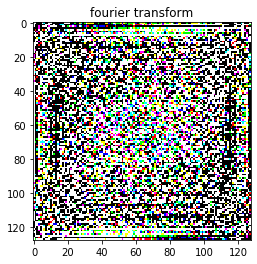

  2%|▏         | 33/2000 [00:00<00:06, 321.91it/s]

generating wavelet features


100%|██████████| 2000/2000 [00:05<00:00, 389.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


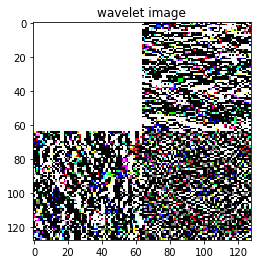

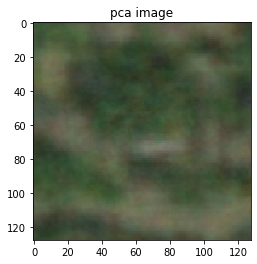

In [3]:
# test out utils file
import features_util

util_dft_X = features_util.dft_features(train_X_sample)
plt.imshow(util_dft_X[0,:,:,:])
plt.title("fourier transform")
plt.show()

util_dwt_X = features_util.wavelet_features(train_X_sample)
plt.imshow(util_dwt_X[0,:,:,:])
plt.title("wavelet image")
plt.show()

util_pca, pca_components = features_util.pca_features(train_X_sample)
plt.imshow(util_pca[0,:,:,:]/255)
plt.title("pca image")
plt.show()